<a href="https://colab.research.google.com/github/QasimWani/simple-transformer/blob/main/mlp/backprop_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# The objective behind this file is to implement several ML models from scratch
# First approach is using sklearn - DONE
# Second approach is using Pytorch (2-layer MLP) - DONE
# Third approach is using numpy by deriving MLP and autograds - DONE

In [2]:
import numpy as np
import torch
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim

import sklearn.datasets

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from imblearn.over_sampling import SMOTE

from collections import Counter, defaultdict

In [3]:
ds = sklearn.datasets.load_breast_cancer()

In [4]:
X, y = ds['data'], ds['target']
# 0 = malignant
# 1 = benign

In [5]:
def visualize_distribution(X: np.ndarray, y: np.ndarray):
  mu = X.mean(axis=0)
  var = X.var(axis=0)

  num_features = len(mu)
  num_classes = len(np.unique(y))

  plt.title("Feature distribution")
  plt.bar(np.arange(num_features), mu, yerr=var ** 0.5)
  plt.show()

  plt.title("Label distribution")
  plt.bar(np.arange(num_classes), Counter(y).values())
  plt.show()

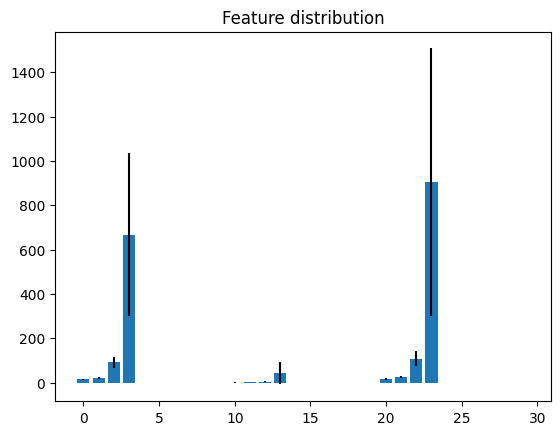

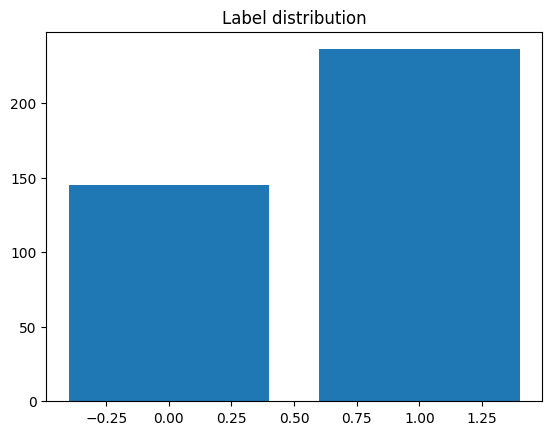

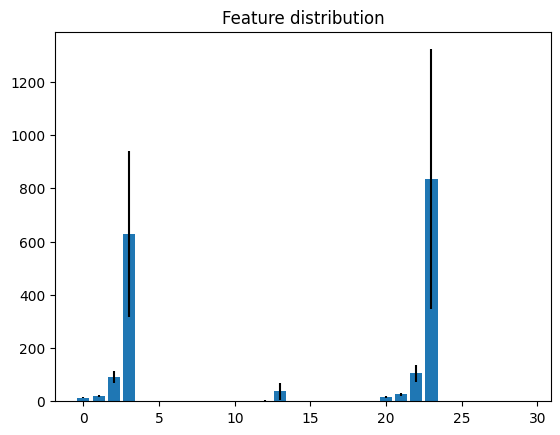

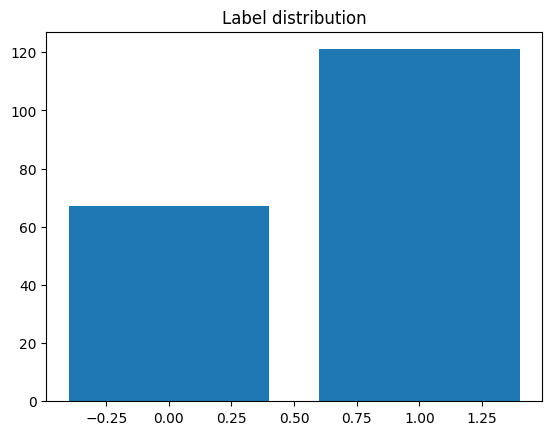

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)


visualize_distribution(X_train, y_train)
visualize_distribution(X_test, y_test)


In [7]:
# Okay, so looking at the chart we will need to do two things:

# 1. normalize x-features
# 2. upweight samples from minority class, i.e. class 0 (malignant)

In [8]:
# Step 1. Train baseline model
baseline_model = sklearn.linear_model.LogisticRegression(random_state=0).fit(X_train, y_train)
baseline_accuracy = sklearn.metrics.accuracy_score(baseline_model.predict(X_test), y_test)
print(baseline_accuracy)

0.9574468085106383


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
# okay, great. so baseline performance is very high. 90%. Now, can we get closer to 100%?

def feature_scaling(data: np.ndarray) -> np.ndarray:
  # implement standarization with 0 mean and 1 unit variance
  mu = data.mean(axis=0)
  var = data.var(axis=0)
  out = (data - mu) / var ** 0.5
  assert np.isclose(out.mean(), 0) and np.isclose(out.var(), 1)
  return out


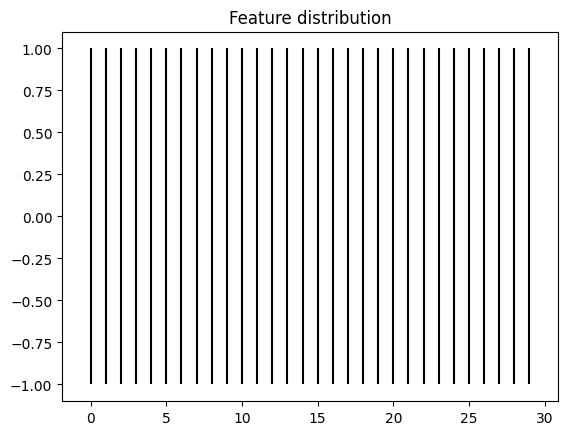

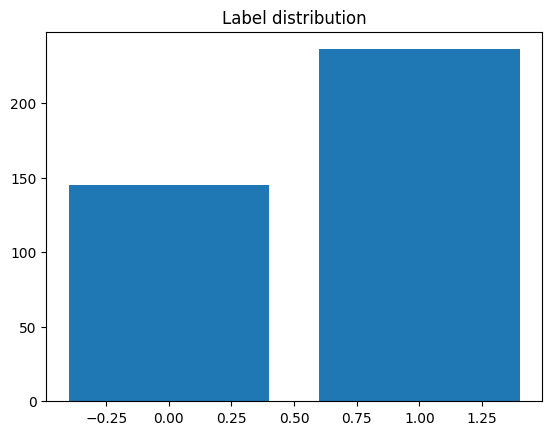

In [10]:
X_train_std = feature_scaling(X_train)
visualize_distribution(X_train_std, y_train)

In [11]:
# Step 2. Train model with scaled input features
baseline_model = sklearn.linear_model.LogisticRegression(random_state=0).fit(X_train_std, y_train)
feature_scaled_accuracy = sklearn.metrics.accuracy_score(baseline_model.predict(feature_scaling(X_test)), y_test)
print(feature_scaled_accuracy)

0.9521276595744681


In [12]:
# Step 3. Interesting. Normalizing input features made no difference. Perhaps we just force class upweighting?
baseline_model = sklearn.linear_model.LogisticRegression(random_state=0, class_weight={0: 0.4, 1: 0.6}).fit(X_train_std, y_train)
class_upweighted_accuracy = sklearn.metrics.accuracy_score(baseline_model.predict(feature_scaling(X_test)), y_test)
print(class_upweighted_accuracy)

0.9680851063829787


In [13]:
# Okay, so we improved performnace by 1 percent point. Now, Step 2 -> can we use a simple MLP to boost performance further?

class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(30, 30 * 4),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(30 * 4, 32),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(32, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.layers(x)

In [14]:
X_train_tensor = torch.tensor(X_train_std, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)[:, None]

X_test_tensor = torch.tensor(feature_scaling(X_test), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)[:, None]

In [15]:
def train_network(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, num_epochs: int):
  model = Network().to(torch.float32)
  optimizer = optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.BCELoss()
  losses = []
  # take gradients every k epochs
  grad_step = 10
  acc_loss = 0.0
  accuracies = []
  for i in range(num_epochs):
    model.train()
    y_hat = model(X_train_tensor)
    loss = criterion(y_hat, y_train_tensor)
    acc_loss = acc_loss + loss
    print(f"{loss}", end='\r')

    # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    if i % grad_step == 0 and i > 0:
      acc_loss.backward()
      optimizer.step()
      acc_loss = 0.0
      optimizer.zero_grad()

    losses.append(loss.item())
    accuracies.append(validate_model(X_test_tensor, y_test_tensor.squeeze(1), model).item())
  return model, losses, accuracies

def validate_model(X, y, model):
  model.eval()
  if isinstance(X, np.ndarray):
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)

  y_hat = model(X).squeeze(1)
  preds = 1 * (y_hat > 0.5)
  score = torch.sum(preds == y) / len(y)
  assert 0 < score < 1, score
  return score


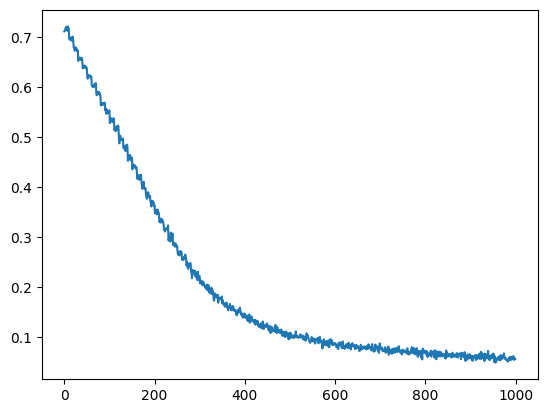

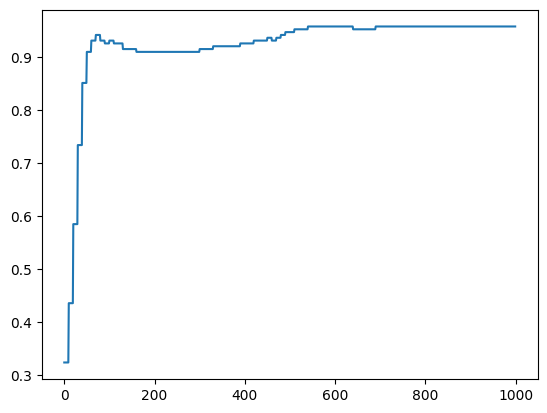

In [16]:
model, losses, accuracies = train_network(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, 1000)
plt.plot(losses)
plt.show()
plt.plot(accuracies)
plt.show()

In [17]:
# Okay, now let's derive this in Numpy. This will be the last step for our puzzle.

In [18]:
def sigmoid(x: np.ndarray) -> np.ndarray:
  x = np.clip(x, -500, 500)
  return 1 / (1 + np.exp(-x))

def d_sigmoid(x: np.ndarray) -> np.ndarray:
  return sigmoid(x) * (1 - sigmoid(x))


def linear(in_features, out_features, scaling_factor:float = 1e-3):
  W = np.random.rand(in_features, out_features) * scaling_factor
  b = np.zeros(out_features) # because x @ w + b
  return W, b.reshape(1, -1)

def relu(x):
  return np.where(x < 0, 0, x)

def d_relu(x):
  return (x > 0).astype(x.dtype)

def loss(y, y_hat):
  return np.mean((y_hat - y) ** 2)

def d_loss(y, y_hat):
  return 2 * (y_hat - y)

In [19]:
class Network:
  def __init__(self, in_features, out_features, eta):
      self.eta = eta # learning rate
      self.in_features = in_features
      self.hidden_size = in_features * 8
      self.out_features = out_features

      ln1 = linear(self.in_features, self.hidden_size)
      self.W1 = ln1[0] # (in_features, hidden_size)
      self.b1 = ln1[1] # (hidden_size)

      ln2 = linear(self.hidden_size, self.out_features)
      self.W2 = ln2[0] # (hidden_size, out_features)
      self.b2 = ln2[1] # (out_features)

  def forward(self, x):
      self.x = x # (batch_size, in_features)
      self.z1 = self.x @ self.W1 + self.b1 # (batch_size, in_features) x (in_features, hidden_size) --> (batch_size, hidden_size)
      self.a1 = relu(self.z1) # (batch_size, hidden_size)

      self.z2 = self.a1 @ self.W2 + self.b2 # (batch_size, out_features) + (out_features) -> (batch_size, out_features)

      # print(f"z2 stats: min={self.z2.min():.2f}, max={self.z2.max():.2f}, mean={self.z2.mean():.2f}")
      # print(f"sigmoid(z2) sample: {sigmoid(self.z2).flatten()[:5]}")  # First 5 values

      self.a2 = sigmoid(self.z2) # (batch_size, out_features)
      return self.a2

  def backward(self, y, y_hat):
      grad = self.fetch_gradients(y, y_hat)
      self.W1 = self.W1 - grad['W1'] * self.eta
      self.b1 = self.b1 - grad['b1'] * self.eta

      self.W2 = self.W2 - grad['W2'] * self.eta
      self.b2 = self.b2 - grad['b2'] * self.eta

  def fetch_gradients(self, y, y_hat):
      batch_size, out_features = y_hat.shape
      grad_a2 = d_loss(y, y_hat)  # dL/da2

      # dL/dz2 = dL/da2 * da2/dZ2
      grad_z2 = grad_a2 * d_sigmoid(self.z2)  # batch_size, out_features
      assert grad_z2.shape == (batch_size, out_features)


      # Now compute the gradients of W and b matrices
      # dL/dw2 = dL/dz2 * dz2/dw2
      grad_w2 = self.a1.T @ grad_z2  # (out_features, batch_size) x (batch_size, hidden_size) -> (out_features, hidden_size)
      assert grad_w2.shape == (self.hidden_size, out_features)

      # dL/db2 = dL/dz2 * dz2/db2 (identity matrix)
      grad_b2 = grad_z2.sum(axis=0) # (out_features)
      assert len(grad_b2) == out_features

      # Now calculate the gradients for the hidden layer
      # grad_a1 = dL/da1 = dL/dz2 * dz2 / da1
      grad_a1 = grad_z2 @ self.W2.T  # (batch_size, out_features) x (out_features, hidden_size) -> (batch_size, hidden_size)
      assert grad_a1.shape == (batch_size, self.hidden_size)

      # grad_z1 = dL/dz1 = dL/da1 * da1/dz1
      grad_z1 = grad_a1 * d_relu(self.z1)  # (batch_size, hidden_size)

      # now compute the weight and bias matrices
      # grad_w1 = dL/dz1 * dz1 / dw1
      grad_w1 = self.x.T @ grad_z1 # (hidden_size, batch_size) x (batch_size, in_features) --> (hidden_size, in_features)
      grad_b1 = grad_z1.sum(axis=0)  # (hidden_size)
      assert grad_w1.shape == (self.in_features, self.hidden_size)

      # Scale gradients by batch size
      for g in [grad_w2, grad_b2, grad_w1, grad_b1]:
        g /= len(g)

      return {
          "W2": grad_w2,
          "b2": grad_b2,
          "W1": grad_w1,
          "b1": grad_b1,
      }

def train(X_train, y_train, X_test, y_test, num_epochs):
  in_features = X_train.shape[-1]
  out_features = y_train.shape[-1]
  model = Network(in_features, out_features, eta=1e-3)
  accuracy = []
  for _ in range(num_epochs):
    y_hat = model.forward(X_train)
    model.backward(y_train, y_hat)
    acc = validate(X_test, y_test, model)
    accuracy.append(acc)
    print(f"Loss: {np.round(loss(y_train, y_hat), 3)}, Accuracy: {acc}", end='\r')
  return model, accuracy

def validate(X, y, model):
  y_hat = model.forward(X)
  preds = 1 * (y_hat > 0.5)
  return (preds == y).sum() / len(y)

In [20]:
model, raw_accuracies = train(X_train, y_train.reshape(-1, 1), X_test, y_test.reshape(-1, 1), num_epochs=1000)

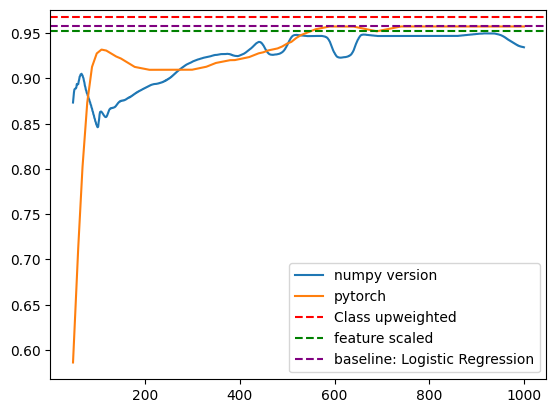

In [21]:
plt.plot(pd.Series(raw_accuracies).rolling(window=50).mean(), label='numpy version')
plt.plot(pd.Series(accuracies).rolling(window=50).mean(), label='pytorch')

plt.axhline(class_upweighted_accuracy, linestyle="--", color="red", label='Class upweighted')
plt.axhline(feature_scaled_accuracy, linestyle="--", color="green", label='feature scaled')
plt.axhline(baseline_accuracy, linestyle="--", color="purple", label='baseline: Logistic Regression')

plt.legend()

plt.show()